# **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [1]:
!pip install -Uqq fastai

In [2]:
import fastai
print(fastai.__version__)
PROJECT_NAME = "FastAI_MNIST"
MODEL_NAME = "fastai_mnist_001.pkl"

2.2.7


## **Load Dataset**

In [28]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

path = untar_data(URLs.MNIST_SAMPLE)

In [29]:
# FastAI extended Posix path w/ their own helper functions
path.ls()
#(path/'train').ls()

(#3) [Path('/home/jovyan/.fastai/data/mnist_sample/train'),Path('/home/jovyan/.fastai/data/mnist_sample/valid'),Path('/home/jovyan/.fastai/data/mnist_sample/labels.csv')]

In [30]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10000.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10011.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10031.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10034.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10042.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10052.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/1007.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10074.png'),Path('/home/jovyan/.fastai/data/mnist_sample/train/3/10091.png')...]

In [31]:
# Load Training Set
train_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'3').ls()])
train_3_tens = train_3_tens.float()/255
train_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'7').ls()])
train_7_tens = train_7_tens.float()/255
train_3_tens.shape,train_7_tens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [32]:
# Load Validation Set
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [33]:
train_x = torch.cat([train_3_tens, train_7_tens]).view(-1, 28*28)
train_y = tensor([1]*len(train_3_tens) + [0]*len(train_7_tens)).unsqueeze(1)
train_x.shape,train_y.shape


(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [34]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_x.shape,valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

`Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

In [35]:
dset = list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [36]:
len(dset)

12396

## **Baseline**
Just average all pixels in (3) and (7) images to make an average 3/7 image.  Then compare test image against avergaes to see if test image is a 3 or 7.

In [37]:
im3_path = threes[1]
# Image => PIL library
im3 = Image.open(im3_path)
# Image Modes: RGB | CMYK | L (Luminance)
print(im3.format, im3.size, im3.mode)

im3

PNG (28, 28) L


In [38]:
# Convert image to numpy array
im3_a = array(im3)
# Convert to Panda Dataframe for display
df = pd.DataFrame(im3_a[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [39]:
# Convert image to tensor
im3_t = tensor(im3)
# Again use Panda DataFrame to display
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [40]:
# Create an array of image tensors
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors),len(seven_tensors)

(6131, 6265)

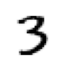

In [41]:
show_image(three_tensors[1]);

In [42]:
# Convert array of tensors into a 3 dimensional tensor
# Normalize values 0 to 1
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

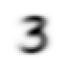

In [43]:
# Average across the first dimension
mean3 = stacked_threes.mean(0)
show_image(mean3);

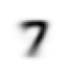

In [44]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

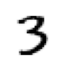

In [45]:
# Take a test 3 and decide if it's more similar to a 3 or 7
a_3 = stacked_threes[1]
show_image(a_3);

In [46]:
# L1 Norm
dist_3_abs = (a_3 - mean3).abs().mean()
# Root Mean Error
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [58]:
# L1 Norm
dist_7_abs = (a_3 - mean7).abs().mean()
# Root Mean Error
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

The distance of test image is closer to a (3) than a (7).

In [53]:
# PyTorch Provides these functions
# - included in the import torch.nn.functional as F
# - l1_loss => L1 Norm
# - mse_loss => Mean Squared Error
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [56]:
# Load Validation Set
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

# L1 Norm Loss Function
def mnist_dist(a, b):
    return (a-b).abs().mean((-1,-2))
    
dist_3_3 = mnist_dist(valid_3_tens, mean3)
dist_3_7 = mnist_dist(valid_3_tens, mean7)

acc_3 = (dist_3_3 < dist_3_7).float().mean()

dist_7_3 = mnist_dist(valid_7_tens, mean3)
dist_7_7 = mnist_dist(valid_7_tens, mean7)

acc_7 = (dist_7_3 > dist_7_7).float().mean()

print(f"%0.3f / %0.3f" % (acc_3, acc_7))

0.917 / 0.985


## **Let's apply SGD**

In [60]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

In [61]:
(train_x[0]*weights.T).sum() + bias

tensor([3.0332], grad_fn=<AddBackward0>)

In [62]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 3.0332],
        [-9.9617],
        [-6.6830],
        ...,
        [10.8647],
        [ 8.6148],
        [-4.9130]], grad_fn=<AddBackward0>)

In [63]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [ True]])

In [64]:
corrects.float().mean().item()

0.30041947960853577

In [65]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [66]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [67]:
preds = linear1(batch)
preds

tensor([[ 3.0332],
        [-9.9617],
        [-6.6830],
        [-6.7614]], grad_fn=<AddBackward0>)

In [69]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()
loss = mnist_loss(preds, train_y[:4])
loss

tensor(6.0932, grad_fn=<MeanBackward0>)

In [70]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.1616), tensor([-1.]))

In [71]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [72]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.3233), tensor([-2.]))

In [73]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.4849), tensor([-3.]))

In [74]:
weights.grad.zero_()
bias.grad.zero_();

In [75]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [76]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [False],
        [False],
        [False]])

In [77]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [78]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

In [79]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [82]:
validate_epoch(linear1)

0.9553

In [83]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9548

In [ ]:
from torch import nn
# Generate a Linear model: y=Wx + B
linear_model = nn.Linear(28*28, 1)
w,b = linear_model.parameters()
params = w,b
w.shape, b.shape

In [ ]:
lr = 0.1
opt = SGD(linear_model.parameters(), lr)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape 

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
def train_model(model, lr, params, epochs):
    for i in range(epochs):
        train_epoch(model, lr, params)
        print(validate_epoch(model), end=' ')

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
train_model(linear_model, lr, params, 20)

In [ ]:
lr = 1.0

dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

linear_model = nn.Linear(28*28, 1)
w,b = linear_model.parameters()
params = w,b
w.shape, b.shape

train_epoch(linear_model, lr, params)
validate_epoch(linear_model)

## **Use FastAI Libraries**

In [148]:
dls = DataLoaders(dl, valid_dl)

def mnist_dist(a, b):
    return (a-b).abs().mean((-1,-2))

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(10, lr=0.01)


epoch,train_loss,valid_loss,batch_accuracy,time
0,-0.537776,-2.938937,0.956820,00:00
1,-2.798858,-6.301553,0.954858,00:00
2,-5.409679,-9.664170,0.954858,00:00
3,-8.248886,-13.026786,0.954367,00:00
4,-11.219706,-16.389402,0.954367,00:00
5,-14.259478,-19.752018,0.953876,00:00
6,-17.332920,-23.114632,0.953876,00:00
7,-20.421989,-26.477253,0.953876,00:00
8,-23.518044,-29.839867,0.953876,00:00
9,-26.617134,-33.202480,0.953876,00:00


In [84]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

dls = DataLoaders(dl, valid_dl)

# dls = ImageDataLoaders.from_folder(path)

def mnist_loss(predictions, targets):
    loss = torch.where(targets==1, 1-predictions, predictions).mean()
#     print(loss)
    return loss

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(10, 0.001)


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.300389,0.408032,0.853778,00:00
1,0.262807,0.343133,0.941609,00:00
2,0.209269,0.263297,0.961727,00:00
3,0.140459,0.169504,0.962709,00:00
4,0.056703,0.058207,0.966634,00:00
5,-0.044159,-0.076394,0.965653,00:00
6,-0.165891,-0.240699,0.967125,00:00
7,-0.313686,-0.442402,0.968597,00:00
8,-0.494274,-0.691172,0.967125,00:00
9,-0.716021,-0.999261,0.964671,00:00


<AxesSubplot:>

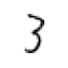

In [85]:
show_image(dls.valid_ds[0][0].view(28,28))

In [86]:
learn.model

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

## **Misc Junk**

In [ ]:
from torch import nn

loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()


print(target.shape)

In [ ]:
# *.T ==> Transpose
weights.shape

In [ ]:
weights.T.shape

In [110]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.161479,0.043295,0.994112,00:05
